In [14]:
%load_ext autoreload
%autoreload 2
from itertools  import pairwise
from threader   import Threader
from geometry   import GHalfLine, GSegment, GPoint, list2gsegments, Angle
from tlayer     import TLayer
from gcode_file import GcodeFile
from pathlib    import Path
from util       import deep_update

from Geometry3D import HalfLine, Segment, Point
from Geometry3D.calc import intersection

import logger, plotting, plot_styles
import plot_helpers, util
import sys
import plotly.graph_objects as go

from plot_helpers import quickplot

#This module has settings specific to our current printer setup
try:
    import ender3v2 as ender3
except ImportError:
    import ender3
    
from manual_printer import ManualPrinter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def isec_with_halfline(halfline:GHalfLine, items, nth=0):
    return sorted(halfline.intersections(items).values(), key=halfline.point.distance)[nth]

def isec_with_angle(origin, angle, items, nth=0):
    o = GPoint(*origin)
    h = GHalfLine(o, o.moved(x=1)).rotated(angle)
    return isec_with_halfline(h, items, nth)

In [77]:
test_root = Path('./example/uist_figure/')
gcode_filename = test_root.joinpath('uist_figure.gcode')

In [138]:
gcode = GcodeFile(gcode_filename, layer_class=TLayer)
gcode.layers[0].add_geometry()
obj = gcode.layers[0].geometry.segments
off = GPoint(10.2, 10.2, .2)
thread = [GPoint(17,0) + off]
thread.append(isec_with_halfline(GHalfLine(thread[0], GPoint((17,6)) + off), obj, nth=1))
thread.append(isec_with_angle(thread[-1], Angle(degrees=150), obj, nth=3))
thread.append(isec_with_angle(thread[-1], Angle(degrees=16), obj, nth=1))
thread

[{ 27.20,  10.20,   0.20},
 { 27.20,  20.84,   0.20},
 { 11.06,  30.15,   0.20},
 { 23.78,  33.80,   0.20}]

In [140]:
logger.restart_logging()
threader = Threader(gcode, 'ender3.yaml', thread, start_anchor=thread[0])
threader.route_model()

Accordion()

Loaded general config: {'initial_thread_angle': 90, 'defaults': {'head_raise': 1, 'head_raise_speed': 200, 
'overlap_length': 2, 'move_feedrate': -1, 'extrude_multiply': -1, 'post_pause': -1}, 'anchor_fixing': 
{'head_raise': 1, 'head_raise_speed': 200, 'overlap_length': 2, 'move_feedrate': 500, 'extrude_multiply': 3, 
'post_pause': 2}, 'extruding': {'head_raise': 1, 'head_raise_speed': 200, 'overlap_length': 2, 'move_feedrate': -1,
'extrude_multiply': 1, 'post_pause': 0}, 'non_extruding': {'head_raise': 1, 'head_raise_speed': 200, 
'overlap_length': 2, 'move_feedrate': 500, 'extrude_multiply': -1, 'post_pause': -1}}

Loaded ring: {'center': {-10.10, -74.20,   0.00}, 'radius': 93, 'angle': 90.000°, 'home_angle': 90.000°, 
'min_move': 0.113°, 'feedrate': 5000, 'motor_gear_teeth': 19, 'ring_gear_teeth': 112, 
'stepper_microsteps_per_rotation': 3200, 'collision_avoid': [{'head_between': [0, 25], 'ring_between': (145.000°, 
185.000°), 'move_ring_to': 185.000°}, {'head_between': [95, 200], 'ring_between': (0.000°, 45.000°), 
'move_ring_to': 45.000°}, {'head_between': [95, 200], 'ring_between': (340.000°, 360.000°), 'move_ring_to': 
340.000°}]}

Loaded bed: {'zero': {-51.00, -65.00,   0.00}, 'size': [110, 220], 'anchor': {-72.50, -65.00,   0.00}}

Ring relative to bed zero: {'center': { 40.90,  -9.20,   0.00}, 'radius': 93, 'angle': 90.000°, 'home_angle': 
90.000°, 'min_move': 0.113°, 'feedrate': 5000, 'motor_gear_teeth': 19, 'ring_gear_teeth': 112, 
'stepper_microsteps_per_rotation': 3200, 'collision_avoid': [{'head_between': [0, 25], 'ring_between': (145.000°, 
185.000°), 'move_ring_to': 185.000°}, {'head_between': [95, 200], 'ring_between': (0.000°, 45.000°), 
'move_ring_to': 45.000°}, {'head_between': [95, 200], 'ring_between': (340.000°, 360.000°), 'move_ring_to': 
340.000°}]}

Bed now: {'zero': {  0.00,   0.00,   0.00}, 'size': [110, 220], 'anchor': {-21.50,   0.00,   0.00}}

Init: {'center': { 40.90,  -9.20,   0.00}, 'radius': 93, 'angle': 90.000°, 'home_angle': 90.000°, 'min_move': 
0.113°, 'feedrate': 5000, 'motor_gear_teeth': 19, 'ring_gear_teeth': 112, 'stepper_microsteps_per_rotation': 3200, 
'collision_avoid': [{'head_between': [0, 25], 'ring_between': (145.000°, 185.000°), 'move_ring_to': 185.000°}, 
{'head_between': [95, 200], 'ring_between': (0.000°, 45.000°), 'move_ring_to': 45.000°}, {'head_between': [95, 
200], 'ring_between': (340.000°, 360.000°), 'move_ring_to': 340.000°}]}

In [159]:
zoom_factor = 2
marker_size = 12
marker_outline_color = 'DarkSlateGray'

plot_styles = {
    #Thread styles
    'future_thread': {'line': dict(color='#b28600', width=2*zoom_factor, dash='dash')},
    'printed_thread':{'line': dict(color='#b28600', width=3*zoom_factor, dash=None)},
    'thread_ring':   {'line': dict(color='#f47a61', width=2*zoom_factor, dash=f'{2*zoom_factor}px,{2*zoom_factor}px')},
    
    #Printed segment styles
    'gc_segs':       {'line': dict(width=3*zoom_factor)},
    'old_segs':      {'line': dict(width=2*zoom_factor, color='LightGray')},
    'to_print':      {'line': dict(width=1*zoom_factor, color='#1192e8', dash='dot'), 'opacity': 1},
    
    #Anchor styles
    'future_anchor':   {'marker': dict(symbol='circle', size=zoom_factor*marker_size,   color='white', line=dict(width=zoom_factor*2, color=marker_outline_color))},
    'next_anchor':     {'marker': dict(symbol='circle', size=zoom_factor*marker_size/2, color='white', line=dict(width=zoom_factor*2, color=marker_outline_color))},
    'anchor':          {'marker': dict(symbol='circle', size=zoom_factor*marker_size,   color='red',   line=dict(width=zoom_factor*2, color=marker_outline_color))},
    'original_anchor': {'marker': dict(symbol='circle', size=zoom_factor*marker_size,   color='LightGray',  line=dict(width=zoom_factor*2, color=marker_outline_color))},
    'thread_fixation': {'marker': dict(symbol='circle', size=zoom_factor*marker_size*1.5,   color='rgba(0,0,255,0.1)', line=dict(width=zoom_factor*1, color='rgba(0,0,255,0.5)'))},
}
plot_styles['next_anchor'] = deep_update(plot_styles['future_anchor'], {'marker': {'size': marker_size/2*zoom_factor}})

paper_styles = deep_update(plot_helpers.styles, plot_styles)

Preview of 14 steps for layer 0


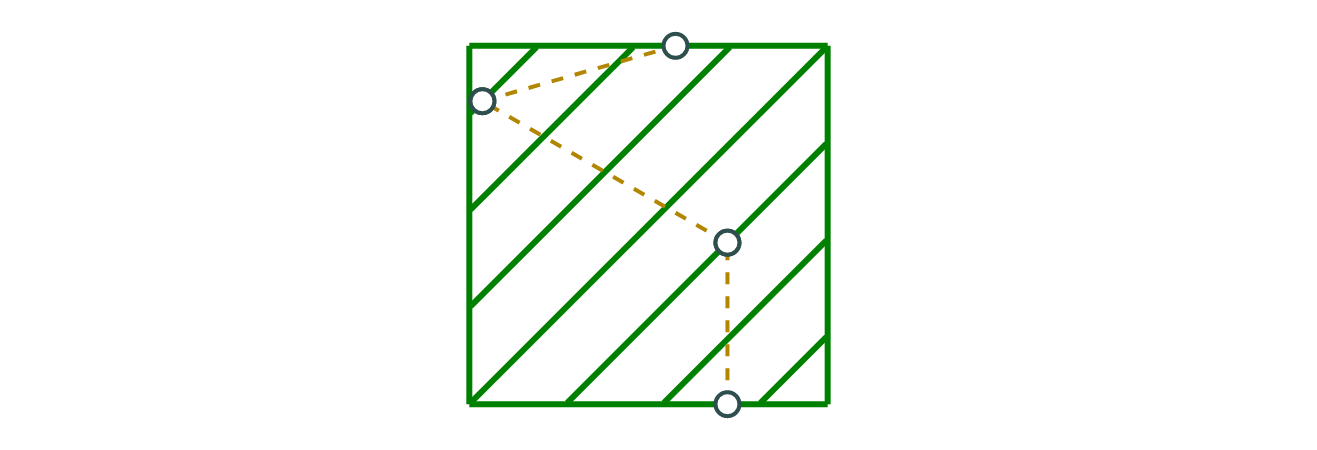

Step 0: Rotate thread at { 27.20,  10.20,   0.20} to overlap next anchor at { 27.20,  20.84,   0.20}
H({ 27.20,  10.20,   0.20}, ↗ 90.00° (  0.00,  10.64,   0.00))


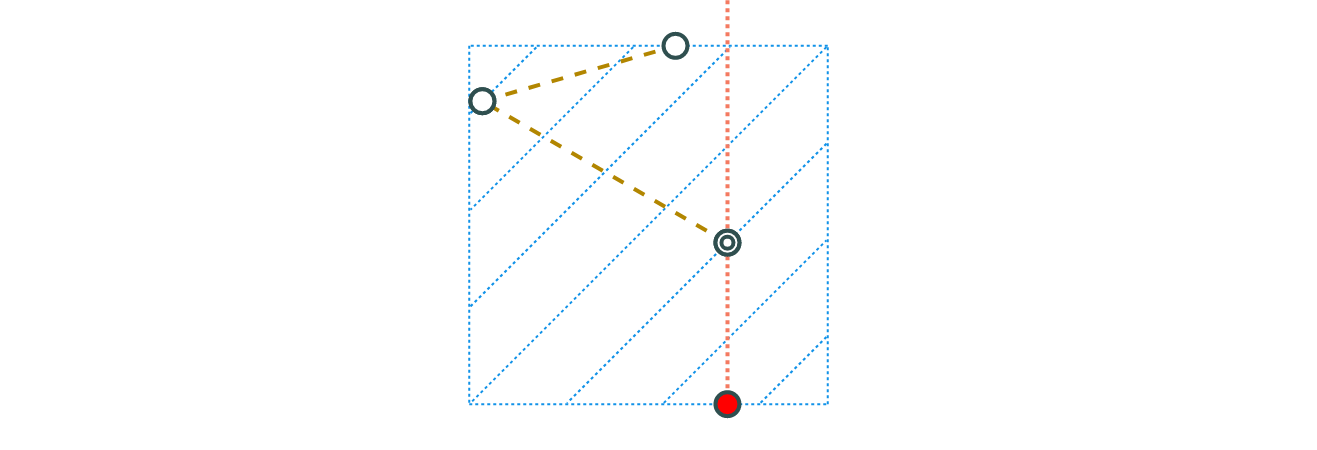

Step 1: Print 1 segment to fix anchor
H({ 27.20,  20.84,   0.20}, ↗ 90.00° (  0.00,  10.64,   0.00))


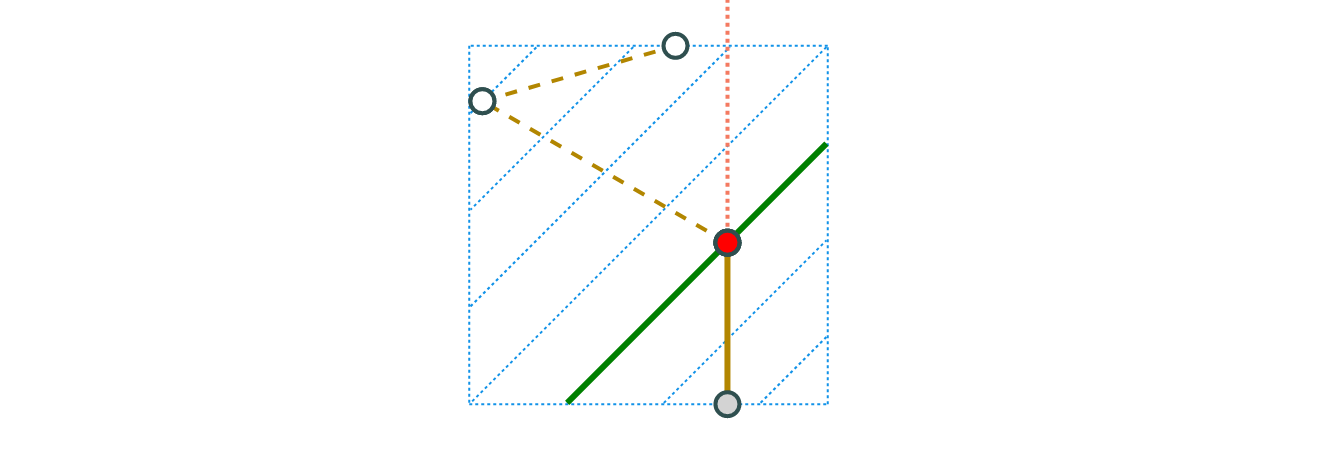

Skip 2
Step 3: Print 2 segments thread doesn't intersect
H({ 27.20,  20.84,   0.20}, ↗ 90.00° (  0.00,  10.64,   0.00))
print_thread_isecs=[{ 27.20,  14.47,   0.20}]


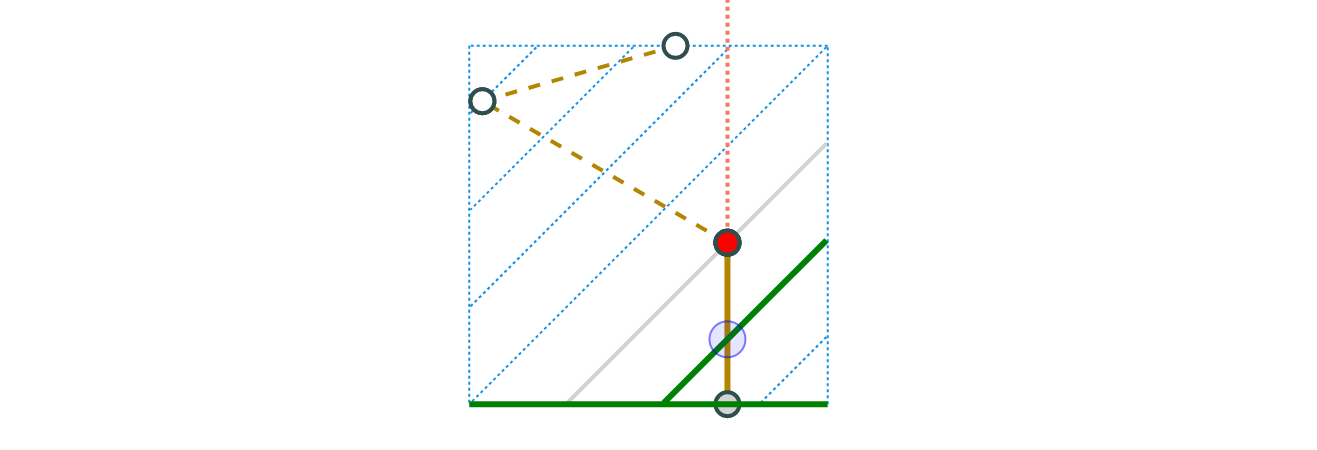

Step 4: Rotate thread at { 27.20,  20.84,   0.20} to overlap next anchor at { 11.06,  30.15,   0.20}
H({ 27.20,  20.84,   0.20}, ↗150.00° (-16.14,   9.32,   0.00))


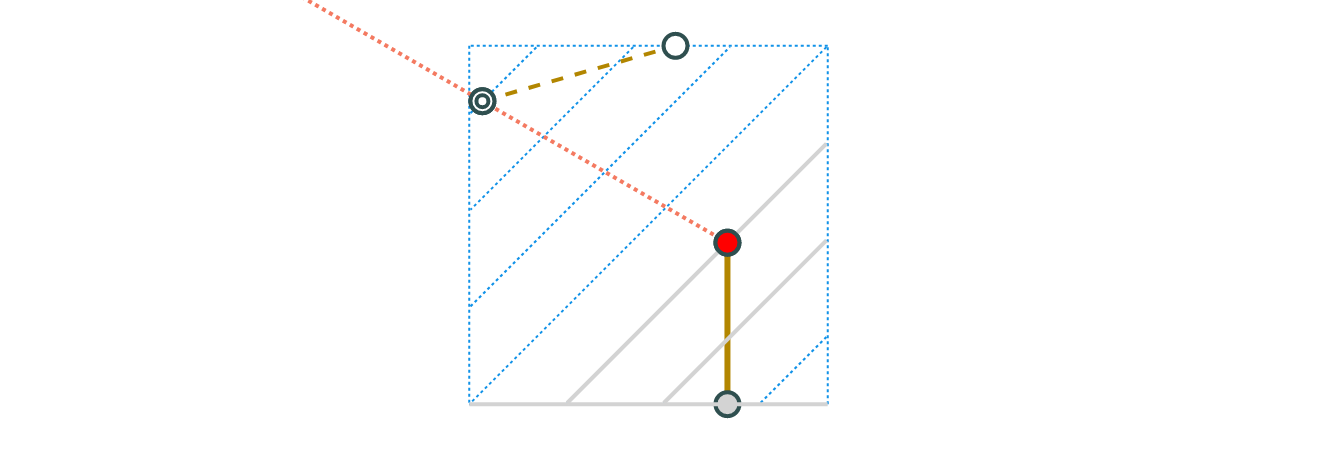

Step 5: Print 1 segment to fix anchor
H({ 11.06,  30.15,   0.20}, ↗150.00° (-16.14,   9.32,   0.00))


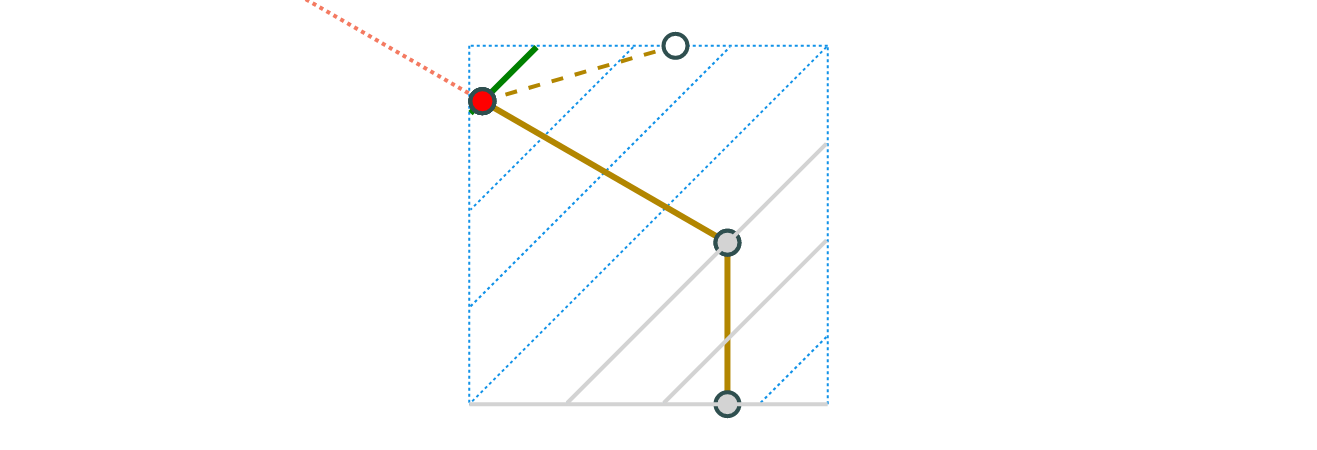

Skip 6
Step 7: Print 2 segments thread doesn't intersect
H({ 11.06,  30.15,   0.20}, ↗150.00° (-16.14,   9.32,   0.00))
print_thread_isecs=[{ 19.13,  25.49,   0.20}, { 23.17,  23.17,   0.20}]


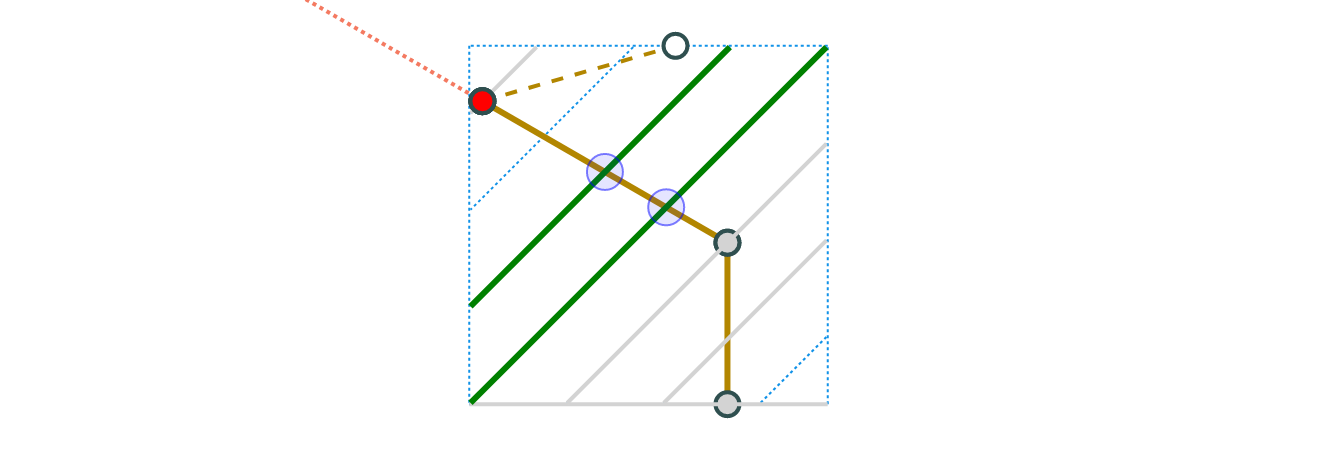

Step 8: Rotate thread at { 11.06,  30.15,   0.20} to overlap next anchor at { 23.78,  33.80,   0.20}
H({ 11.06,  30.15,   0.20}, ↗ 16.00° ( 12.72,   3.65,   0.00))


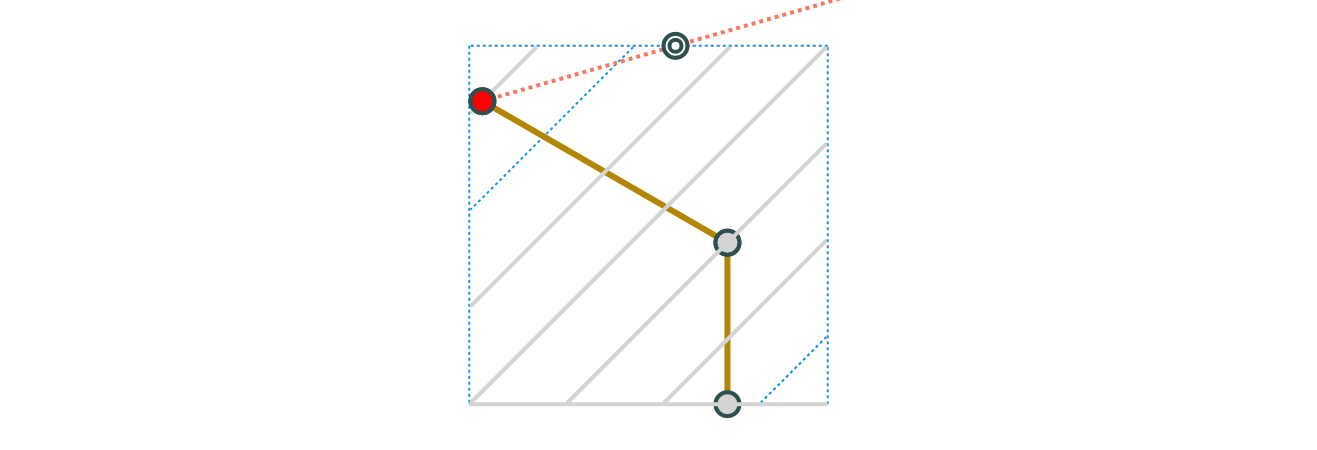

Step 9: Print 1 segment to fix anchor
H({ 23.78,  33.80,   0.20}, ↗ 16.00° ( 12.72,   3.65,   0.00))


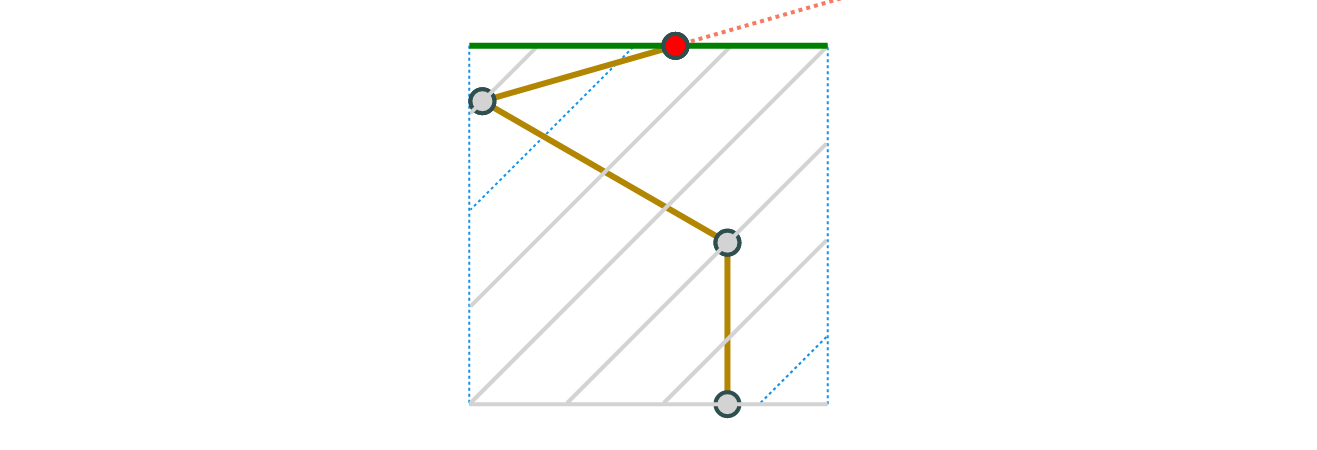

Skip 10
Step 11: Print 1 segments thread doesn't intersect
H({ 23.78,  33.80,   0.20}, ↗ 16.00° ( 12.72,   3.65,   0.00))
print_thread_isecs=[{ 15.10,  27.82,   0.20}, { 19.98,  32.71,   0.20}]


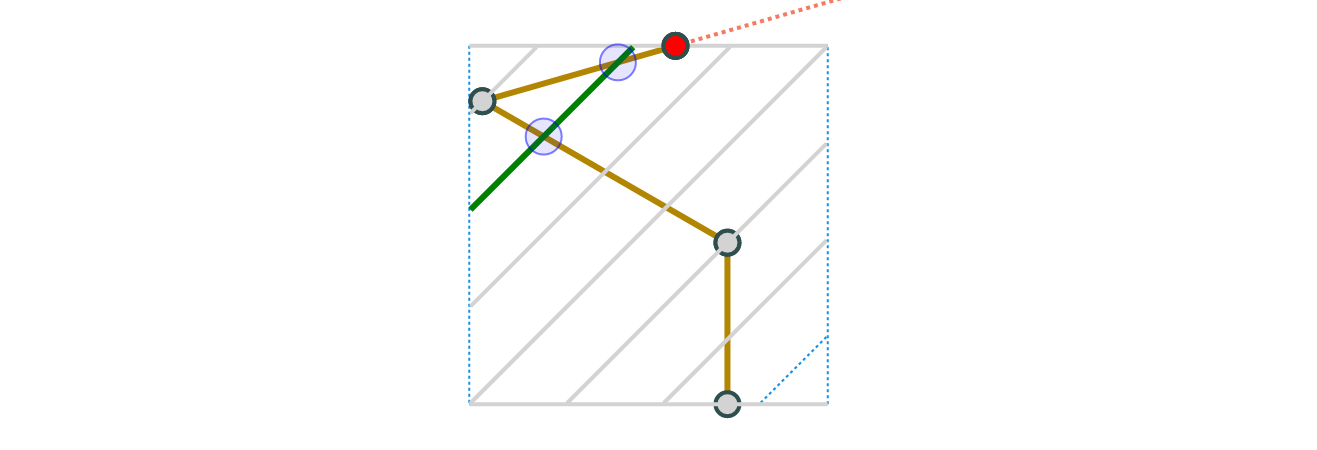

Skip 12
Step 13: Print 3 segments thread doesn't intersect
H({ 23.78,  33.80,   0.20}, ↗ 16.00° ( 12.72,   3.65,   0.00))


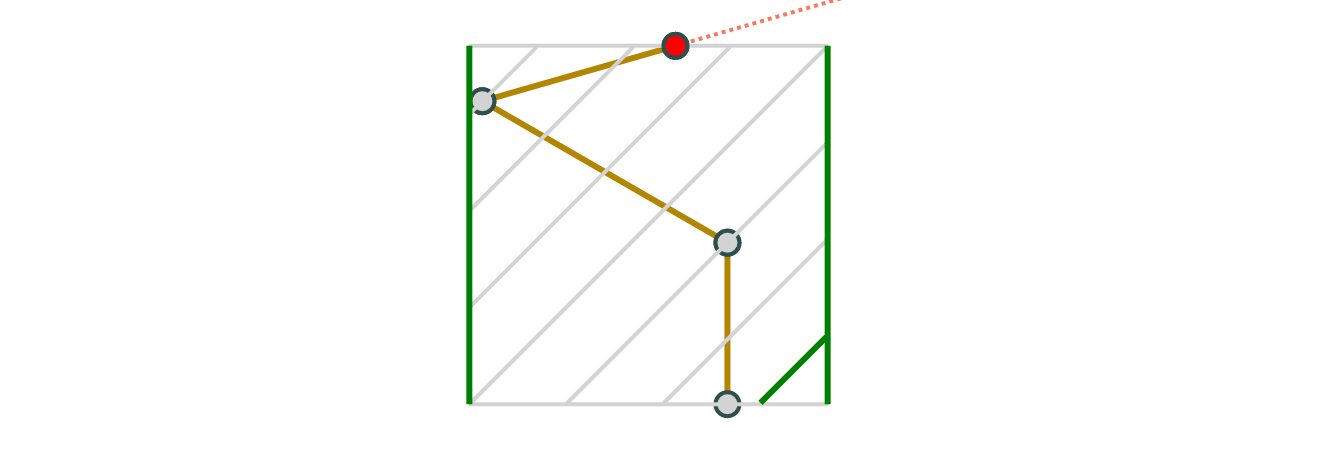

Finished routing this layer


In [160]:
test_layer = 0
figs = plotting.plot_steps(threader.layer_steps[test_layer], template='plotly_white',
    styles=paper_styles,
    show_args={
        'xaxis':dict(showgrid=False, showticklabels=False, zeroline=False),
        'yaxis':dict(showgrid=False, showticklabels=False, zeroline=False),
    }, #show=False
                          )#, prev_layer=gcode.layers[test_layer-1], prev_layer_only_outline=False, preview_layer=False)
#plotting.plot_test(threader.layer_steps[1])

In [158]:
from glob import glob
for i,fig in enumerate(figs):
    fig.write_image(f'algorithm-{i:02}.pdf')